# Jupyter Notebook for the analysis of the Model for Retinoic Acid resistance in Acute Promyelocytic Leukaemia

This model analysis workflow was designed to assses the dynamical properties of a logical network model constructed to study Retinoic Acid resistance in Acute Promyelocytic Leukaemia. Execution of the command lines requires installation of the CoLoMoTo environment (https://colomoto.github.io/).  
The model integrates signalling, transcriptional and epigenetic regulatory mechanisms underlying the APL cell responses to RA treatment depending on their genetic background. The explicit inclusion of the histone methyltransferase EZH2 allowed to assess its role in the maintenance of the resistant phenotype, distinguishing between its canonical and non-canonical activities. Ultimately, this model offers a solid basis to assess the roles of novel regulatory mechanisms, as well as to explore novel therapeutical approaches *in silico*.

The analysis workflow includes the following steps:

* loading of the logical model from the GINsim repository and display of the logical regulatory graph(LRG),
* identification of the attractors (trapspaces and fixpoints),
* attractors commitment analysis,
* definition of variants of the model to represent EZH2 perturbations cases,
* stochastic simulations to evaluate the impact of EZH2 perturbations on the probabilities to reach the differentiated and proliferative phenotypes,
* a comprehensive perturbation analysis to determine the nodes with stronger contributions to the differentiated or proliferative phenotypes.

In [1]:
#Import of the necessary tools and python packages for the analysis.
import ginsim
import biolqm
import pyboolnet
import maboss

from colomoto_jupyter import tabulate

from pyboolnet.file_exchange import bnet2primes, primes2bnet
from pyboolnet.prime_implicants import find_constants, create_variables, list_input_combinations, create_constants
from pyboolnet.repository import get_primes
from pyboolnet.trap_spaces import compute_trap_spaces, compute_steady_states

from pyboolnet.model_checking import model_checking
from pyboolnet.attractors import compute_attractors
from pyboolnet.commitment_diagrams import compute_commitment_diagram, create_commitment_piechart, commitment_diagram2image

This notebook has been executed using the docker image `colomoto/colomoto-docker:2023-10-01`

INFO generated new fontManager


## Loading of the logical model and display of the Logical Regulatory Graph

In [2]:
#Load the model in GINsim format and display the Logical Regulatory Graph.
lrg = ginsim.load("http://ginsim.org/sites/default/files/SanchezVillanueva_RA_APL_model_14Mar2024.zginml")
ginsim.show(lrg)

Downloading http://ginsim.org/sites/default/files/SanchezVillanueva_RA_APL_model_14Mar2024.zginml

WARNING Do not forget attaching "SanchezVillanueva_RA_APL_model_14Mar2024.zginml" file with your notebook


/notebook/SanchezVillanueva_RA_APL_model_14Mar2024.zginml

This **logical regulatory graph** encompasses 38 nodes and 125 signed arcs. Internal nodes can be associated with four main functions: cell cycle arrest (red); cell cycle progression (green); granulocytic differentiation (yellow); and epigenetic regulation (orange). Oval nodes denote Boolean components, whereas the rectangular one denotes a ternary component (RA). Green arrows and red blunt arcs denote positive and negative regulatory influences, respectively. Three inputs nodes (light blue) denote the presence of translocations (PLM_RARAg or PLZF_RARAg), as well as the RA level considered (No RA: 0, physiological level: 1, and pharmacological level: 2).The graph is complemented with logical rules determining the target level of each node as a function of the levels of its regulators. The model (including logical rules and model annotations) is available in the GINsim repository (http://ginsim.org/node/256), as well as in the BioModels database (SBML qual format).

## Identification of the attractors

In logical models, attractors can be of two types: single stable states (also named fixpoints), or cyclic attractors, made of circular sequences of two or more states, according to the logical rules.

The trapspaces function of bioLQM enables the identification of both types of attractors, while the fixpoints function allows to determine only the stable states. Using both functions we were able to detect that the number of stable states equals the number of minimal trapspaces, this presumably rules out the existence of cyclic attractors. This hypothesis is further verified with the commitment analysis showed below, as all states lead to the stable states in each of the diagrams.

In [3]:
#Computation of the number of trapspaces and fixpoints of the model.
lqm = ginsim.to_biolqm(lrg)
print("Number of attractors of the model:")
print("trapspaces: "+str(len(biolqm.trapspaces(lqm, "terminal"))))
print("stable states: "+str(len(biolqm.fixpoints(lqm)))+"\n")

Number of attractors of the model:
trapspaces: 21
stable states: 21



In [4]:
#Display of the stable states over selected reporter components
rep_comp = ["RA", "PML_RARAg", "PLZF_RARAg", "PML", "PLZF", "p53", "p21", "p27", "E2F", "MYC", "RARb2", "CEBPAB", "EZH2", "PRC2", "PU1"]
fps = biolqm.fixpoints(lqm)
fpsproj = biolqm.fixpoints(lqm, autoconvert=False).project_on_components(rep_comp)
display(biolqm.states_to_dataframe(fpsproj).style.set_properties(**{'text-align': 'center'}))

The resulting stable states are listed, focusing on the values of a subset of nodes enabling the association of each of the stable states with a specific cellular phenotype.
The list covers all possible input combinations, including situations corresponding to the simultaneous presence of PML_RARAg and PLZF_RARAg fusions, which has never been reported. This genetic background is thus not further considered in the simulations presented below.  
Using GINsim, we can also visualise any of these stable states directly on the regulatory graph.

In [5]:
# Display the 8th stable state on the regulatory graph 
ginsim.show(lrg, fps[8])

Nodes in blue are active, while the nodes in white are inactive. This stable state thus corresponds to the differentiated phenotype reached in the presence of medium level of RA (light blue), but in the absence of PML-RARA and PLZF-RARA fusion proteins.

## Commitment analysis
PyBoolnet was used to compute the set of states leading towards each of the attractors. It relies in the model checking tool NuSMV-a.  
A commitment diagram is generated for each of the input combinations: the resulting diagrams are saved in json format and as images in PDF format.

In [6]:
#Export from biolqm to pyboolnet
bnet = biolqm.save(lqm, "bnet.bnet", "bnet")
pbn = bnet2primes(bnet)

In [7]:
#Definition on relevant input combinations
WT_RA0_pbn = create_constants(pbn, {'PLZF_RARAg': 0, 'PML_RARAg': 0, 'RA_b1':0, 'RA_b2': 0}, copy= True)
WT_RA1_pbn = create_constants(pbn, {'PLZF_RARAg': 0, 'PML_RARAg': 0, 'RA_b1':1, 'RA_b2': 0}, copy= True)
WT_RA2_pbn = create_constants(pbn, {'PLZF_RARAg': 0, 'PML_RARAg': 0, 'RA_b1':1, 'RA_b2': 1}, copy= True)
PM_RA0_pbn = create_constants(pbn, {'PLZF_RARAg': 0, 'PML_RARAg': 1, 'RA_b1':0, 'RA_b2': 0}, copy= True)
PM_RA1_pbn = create_constants(pbn, {'PLZF_RARAg': 0, 'PML_RARAg': 1, 'RA_b1':1, 'RA_b2': 0}, copy= True)
PM_RA2_pbn = create_constants(pbn, {'PLZF_RARAg': 0, 'PML_RARAg': 1, 'RA_b1':1, 'RA_b2': 1}, copy= True)
PZ_RA0_pbn = create_constants(pbn, {'PLZF_RARAg': 1, 'PML_RARAg': 0, 'RA_b1':0, 'RA_b2': 0}, copy= True)
PZ_RA1_pbn = create_constants(pbn, {'PLZF_RARAg': 1, 'PML_RARAg': 0, 'RA_b1':1, 'RA_b2': 0}, copy= True)
PZ_RA2_pbn = create_constants(pbn, {'PLZF_RARAg': 1, 'PML_RARAg': 0, 'RA_b1':1, 'RA_b2': 1}, copy= True)

primes_dict = {}
primes_dict['WT_RA0_pbn']=WT_RA0_pbn
primes_dict['WT_RA1_pbn']=WT_RA1_pbn
primes_dict['WT_RA2_pbn']=WT_RA2_pbn
primes_dict['PM_RA0_pbn']=PM_RA0_pbn
primes_dict['PM_RA1_pbn']=PM_RA1_pbn
primes_dict['PM_RA2_pbn']=PM_RA2_pbn
primes_dict['PZ_RA0_pbn']=PZ_RA0_pbn
primes_dict['PZ_RA1_pbn']=PZ_RA1_pbn
primes_dict['PZ_RA2_pbn']=PZ_RA2_pbn


In [8]:
#Commitment analysis for each of the input combinations. This step takes some time.
#A diagram in json format will be generated, and a PDF file with the image of the commitment diagram.
attractors_dict={}
diagrams_dict = {}
for k, v in primes_dict.items():
    attractors = compute_attractors(primes=v, update="asynchronous")
    attractors_dict['attractors'+'_'+str(k)]=attractors
    diagram = compute_commitment_diagram(attractors=attractors, fname_json=str(k)+'_commitment_diagram.json', edge_data=True)
    diagrams_dict['diagram'+'_'+str(k)]=diagram
    if len(attractors_dict['attractors'+'_'+str(k)]['attractors'])==1:
        continue
    commitment_diagram2image(diagram=diagram, fname_image=str(k)+'_commitment_diagram.pdf', style_inputs=True, style_edges=True, style_ranks=True, first_index= 1)

INFO attractors.completeness(..)
INFO created /tmp/pyboolnet_ky8d_fpn
INFO yes
INFO  working on minimal trapspace 1/2: 111000111110111011110000001010001110000
INFO attractors.univocality(..)
INFO  yes
INFO attractors.faithfulness(..)
INFO yes
INFO attractors.find_attractor_state_by_randomwalk_and_ctl(..)
INFO find_attractor_state_by_randomwalk_and_ctl(..)
INFO len(primes)=39, update=asynchronous, length=390, attempts=10
INFO trial 0
INFO start: 111000111110111011110000001010001110000
INFO end: 111000111110111011110000001010001110000
INFO created /tmp/pyboolnet_zvfd6os3
INFO is attractor state
INFO  working on minimal trapspace 2/2: 000000110001011110011001000010001001111
INFO attractors.univocality(..)
INFO  yes
INFO attractors.faithfulness(..)
INFO yes
INFO attractors.find_attractor_state_by_randomwalk_and_ctl(..)
INFO find_attractor_state_by_randomwalk_and_ctl(..)
INFO len(primes)=39, update=asynchronous, length=390, attempts=10
INFO trial 0
INFO start: 000000110001011110011001000010

# Analysis of EZH2 perturbations  
In order to analyse the role of EZH2 in cell fate decision, we consider two variants of the APL model:
i) a complete knockdown of EZH2, or the use of a specific degrader such as MS1943 (model variant EZH2 KO);
ii) an edgetic perturbation amounting to block the regulatory influence of EZH2 onto PCR2, mimicking the experimental inhibition of EZH2 methyltransferase activity with a chemical agent such as GSK126 (model variant EZH2:PRC20)

## Definition of EZH2 Model variants with bioLQM

In [9]:
#Definition of mutants with biolqm
lqm = ginsim.to_biolqm(lrg)
lqm_EZH2_PRC20 = biolqm.perturbation(lqm, "EZH2:PRC2%0")
lqm_EZH2KO = biolqm.perturbation(lqm, "EZH2%0")

## Computation of the attractors for the two EZH2 model variants

In [10]:
#Computation of the number of trapspaces and fixpoints for the two EZH2 perturbations with bioLQM.

print("Number of attractors for the edgetic perturbation affecting the effect of EZH2 onto PRC2 (EZH2_PRC20):")
print("trapspaces: "+str(len(biolqm.trapspaces(lqm_EZH2_PRC20, "terminal"))))
print("stable states: "+str(len(biolqm.fixpoints(lqm_EZH2_PRC20)))+"\n")

print("Number of attractors for EZH2 knockout (EZH2KO):")
print("trapspaces: "+str(len(biolqm.trapspaces(lqm_EZH2KO, "terminal"))))
print("stable states: "+str(len(biolqm.fixpoints(lqm_EZH2KO)))+"\n")

Number of attractors for the edgetic perturbation affecting the effect of EZH2 onto PRC2 (EZH2_PRC20):
trapspaces: 21
stable states: 21

Number of attractors for EZH2 knockout (EZH2KO):
trapspaces: 12
stable states: 12



In [11]:
#Display of the fixpoints for the EZH2_PRC20 condition over selected reporter components.
rep_comp = ["RA", "PML_RARAg", "PLZF_RARAg", "PML", "PLZF", "p53", "p21", "p27", "E2F", "MYC", "RARb2", "CEBPAB", "EZH2", "PRC2", "PU1"]
fps_EZH2_PRC20 = biolqm.fixpoints(lqm_EZH2_PRC20, autoconvert=False).project_on_components(rep_comp)
display(biolqm.states_to_dataframe(fps_EZH2_PRC20).style.set_properties(**{'text-align': 'center'}))

After comparing this list with the list of stable states obtained above, we conclude that there is no significant impact of this epigenetic perturbation.

In [12]:
#Display of the fixpoints for the EZH2KO condition over selected reporter components.
fps_EZH2KO = biolqm.fixpoints(lqm_EZH2KO, autoconvert=False).project_on_components(rep_comp)
display(biolqm.states_to_dataframe(fps_EZH2KO).style.set_properties(**{'text-align': 'center'}))

The loss-of-function of EZH2 leads to the loss of the 9 stable states corresponding to the proliferative phenotype.

## Stochastic simulations to evaluate the impact of EZH2 perturbations
In order to further characterise the respective impacts of the two EZH2 peturbations, we performed stochastic simulations of the APL model for three conditions:  
* No perturbation  
* EZH2:PRC20  
* EZH2KO

The simulations were performed with the software MaBoSS, using a state representing the Granulocyte-monocyte progenitor stage as initial state, with RA set to 2, PLZF_RARAg, RAR, PML, PLZF, Usp37, CoAct_COMP, EZH2, PRC2, CoRep_COMP, CDKN2D, pRb, Skp2, Mdm2, CAK, CycA2, CycD, CycE, CDK4_6, CDK2, E2F, MYC, Egr1, Dusp6, JUNB, OCT1, Runx1, PU1, CEBPAB and CEBPE all set to 1, while the rest of the nodes were set to 0.


In [13]:
#Export from biolqm to maboss
maboss_models = {}
mbs = biolqm.to_maboss(lqm)
maboss_models['No perturbation']=mbs

mbs_EZH2_PRC20 = biolqm.to_maboss(lqm_EZH2_PRC20)
maboss_models['EZH2 PRC20']=mbs_EZH2_PRC20

mbs_EZH2KO = biolqm.to_maboss(lqm_EZH2KO)
maboss_models['EZH2KO']=mbs_EZH2KO

Warning, node RA_b1 was previously bound to other nodes
Warning, node RA_b1 was previously bound to other nodes
Warning, node RA_b1 was previously bound to other nodes


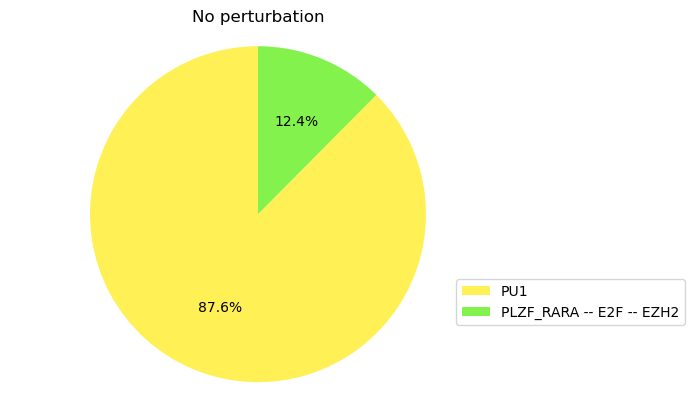

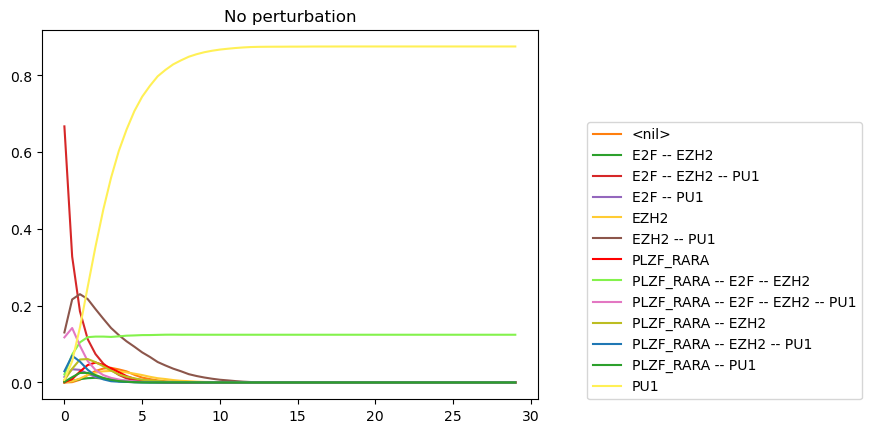

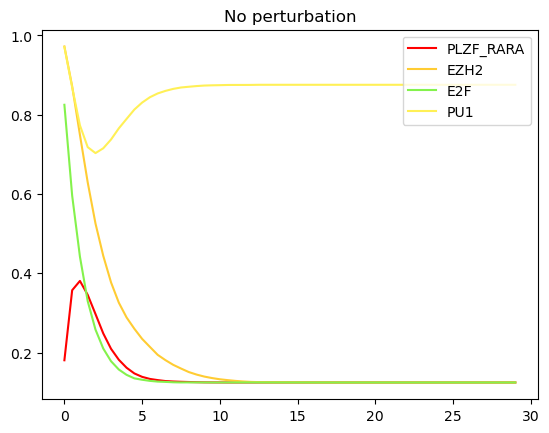

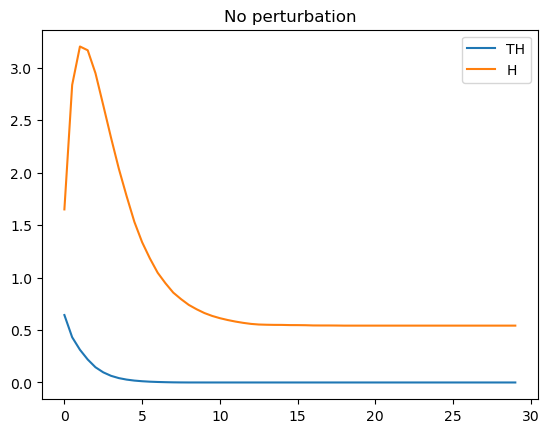

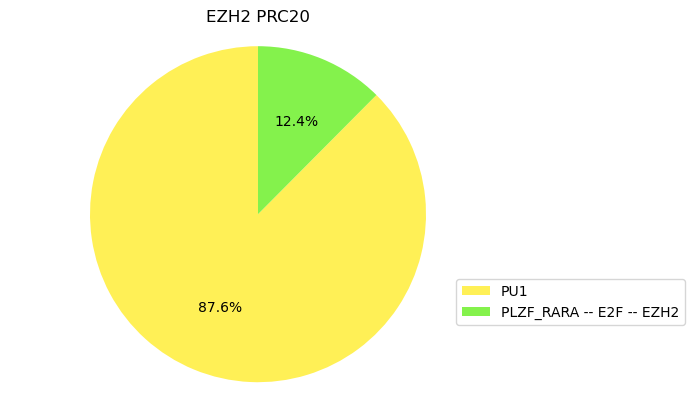

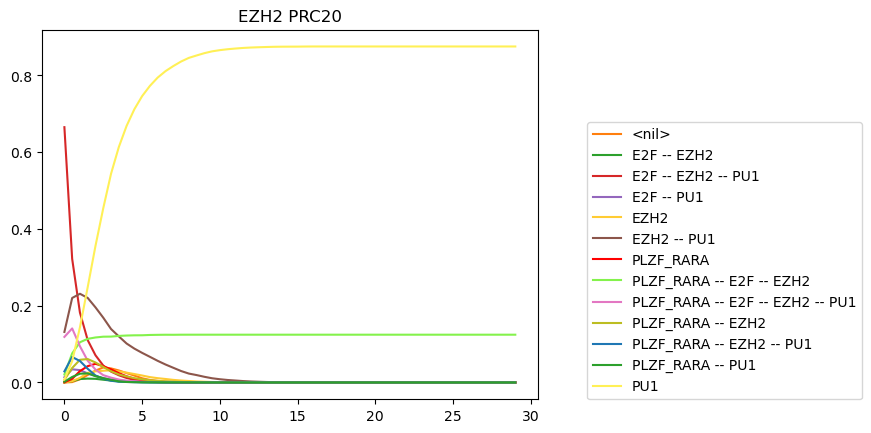

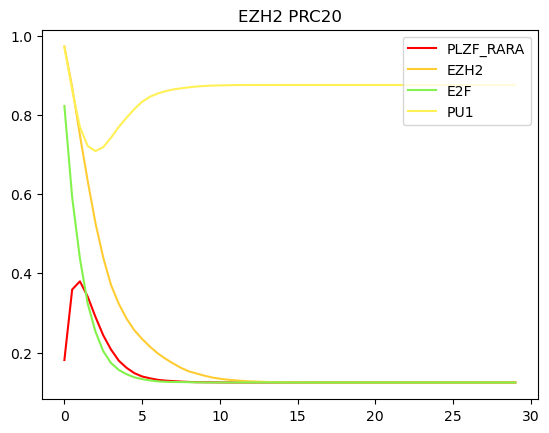

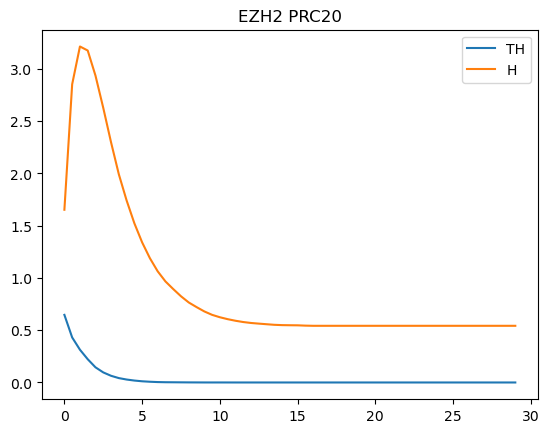

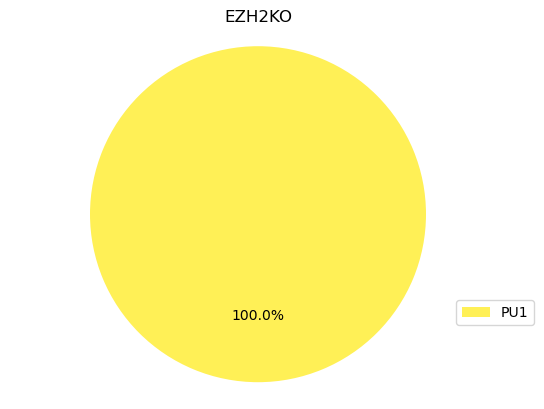

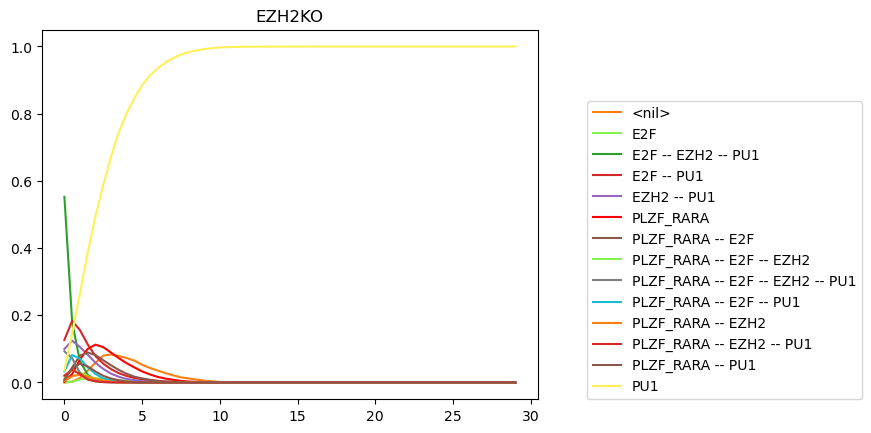

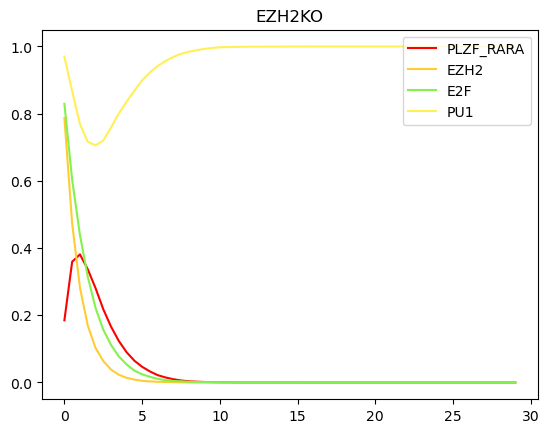

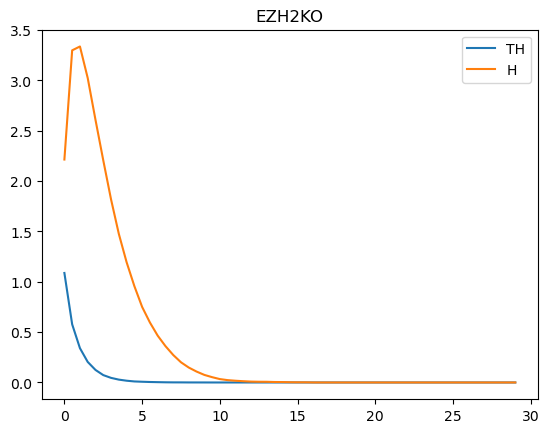

In [14]:
#Stochastic simulations for the two EZH2 perturbation conditions + control.

#Definition of the visualisation (color-node) pairs.
import matplotlib.pyplot as plt
for k, v in maboss_models.items():
    E2F = "E2F"
    p21 = "p21"
    p27 = "p27"
    MYC = "MYC"
    CEBPAB = "CEBPAB"
    PU1 = "PU1"
    EZH2 = "EZH2"
    PLZF_RARA = "PLZF_RARA"
    CEBPAB_p27 = "CEBPAB -- p27"
    PLZF_RARA_E2F_EZH2 = "PLZF_RARA -- E2F -- EZH2"

    v.palette[E2F] = "#84F24C"
    v.palette[p21] = "#FD817B"
    v.palette[p27] = "#FD817B"
    v.palette[MYC] = "#84F24C"
    v.palette[CEBPAB] = "#FFF056"
    v.palette[PU1] = "#FFF056"
    v.palette[EZH2] = "#FFCC33"
    v.palette[PLZF_RARA] = "#FF0000"
    v.palette[CEBPAB_p27] = "#FFF056"
    v.palette[PLZF_RARA_E2F_EZH2] = "#84F24C"

#Definition of the outputs.
    v.network.set_output(["E2F", "PU1", "EZH2", "PLZF_RARA"])

#Definition of the simulation parameters.
    maboss.set_nodes_istate(v, ["RA_b1",
                                "RA_b2",
                                "PLZF_RARAg",
                                "RAR",
                                "PML",
                                "PLZF",
                                "Usp37",
                                "CoAct_COMP",
                                "EZH2",
                                "PRC2",
                                "CoRep_COMP",
                                "CDKN2D",
                                "pRb",
                                "Skp2",
                                "Mdm2",
                                "CAK",
                                "CycA2",
                                "CycD",
                                "CycE",
                                "CDK4_6",
                                "CDK2",
                                "E2F",
                                "MYC",
                                "Egr1",
                                "Dusp6",
                                "JUNB",
                                "OCT1",
                                "Runx1",
                                "PU1",
                                "CEBPAB",
                                "CEBPE"],
                            [0, 1])
    
    v.update_parameters(max_time=30)
    simres = v.run()
    simres.plot_piechart()
    plt.title(k)
    simres.plot_trajectory()
    plt.title(k)
    simres.plot_node_trajectory()
    plt.title(k)
    simres.plot_entropy_trajectory()
    plt.title(k)

The average results obtained over 10 000 MaBoSS simulations for each of the three conditions are displayed.  
The time-plots show the evolution of the mean values of representative cell markers and cell states in time.  
The pie charts display the proportion of simulations leading to each stable state at the end of these simulations (i.e. at time 30, arbitrary units).  
The last plots display the evolution of the state entropy (H) and of the transition entropy (TH) over time.


From the comparison of the control with the EZH2_PRC20 case, we can conclude that the suppression of the influence of EZH2 onto PCR2 has a very marginal impact on cell fate decision.
In contrast, the comparison of the control with the EZH2KO case, we can conclude that a full knockout of EZH2 has drastic impact on cell fate decision, eliminating the proliferative attractor.


# Comprehensive perturbation analysis
In order to determine which nodes significantly impact cell fate decision, we can further use MaBoSS to perform stochastic simulations for gain-of-function and loss-of-function of selected nodes.  
Here also, a state representing the Granulocyte-monocyte progenitor stage was used as initial state, with RA set to 2, PLZF_RARAg, RAR, PML, PLZF, Usp37, CoAct_COMP, EZH2, PRC2, CoRep_COMP, CDKN2D, pRb, Skp2, Mdm2, CAK, CycA2, CycD, CycE, CDK4_6, CDK2, E2F, MYC, Egr1, Dusp6, JUNB, OCT1, Runx1, PU1, CEBPAB, CEBPE all set to 1, while the rest of the nodes were set to 0.

/opt/conda/lib/python3.10/site-packages/maboss/results/baseresult.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(1,1)


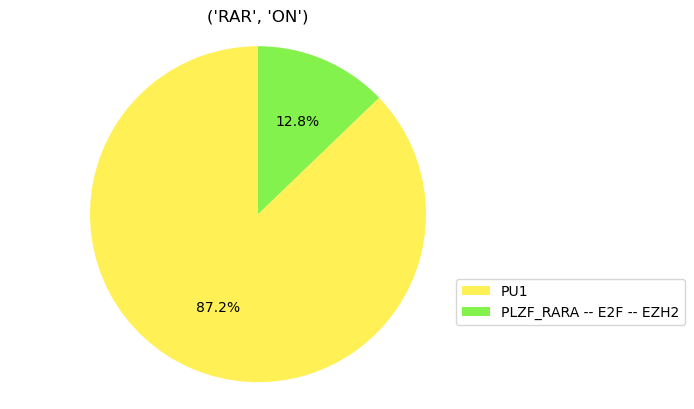

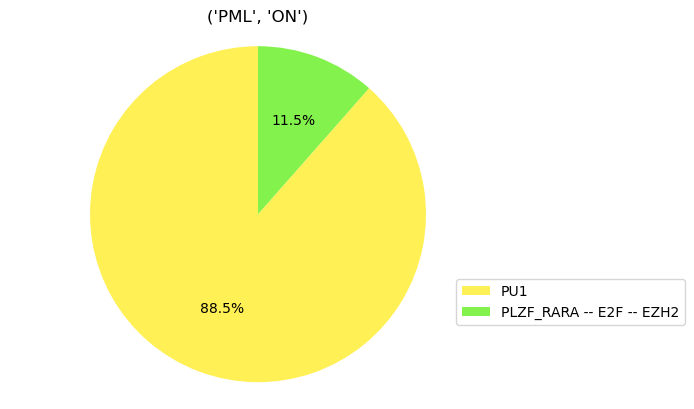

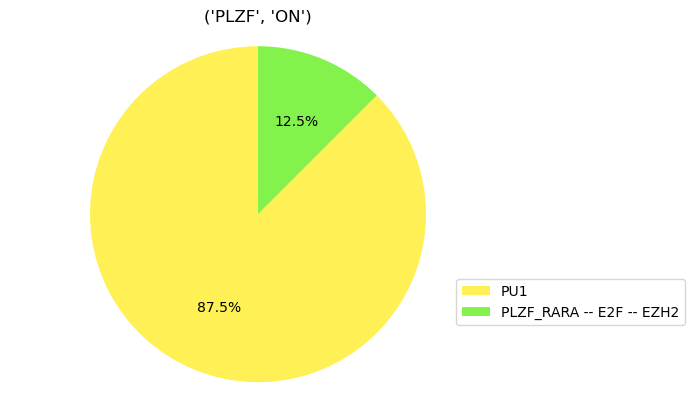

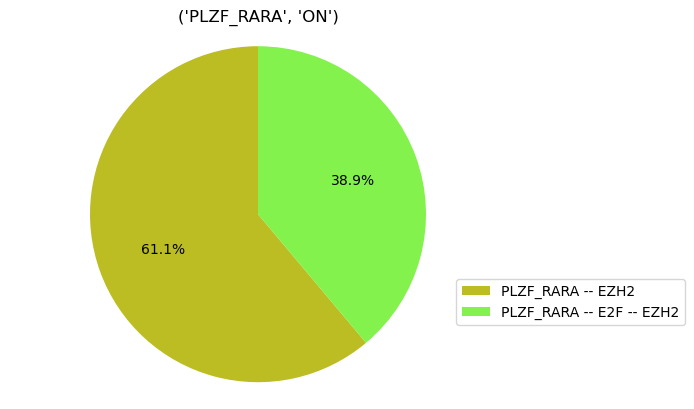

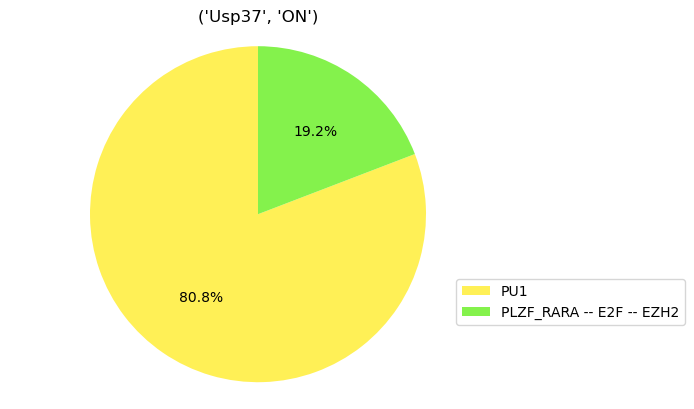

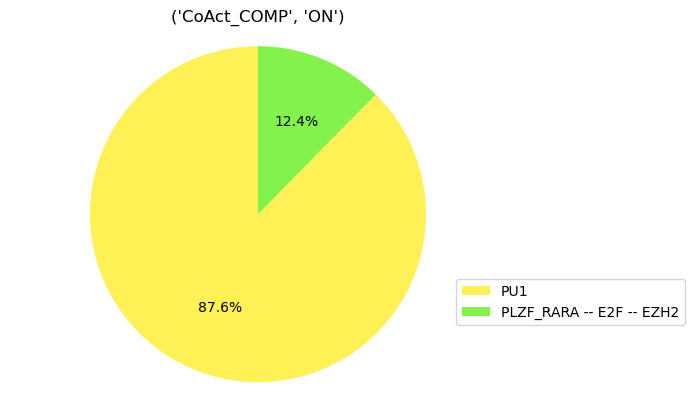

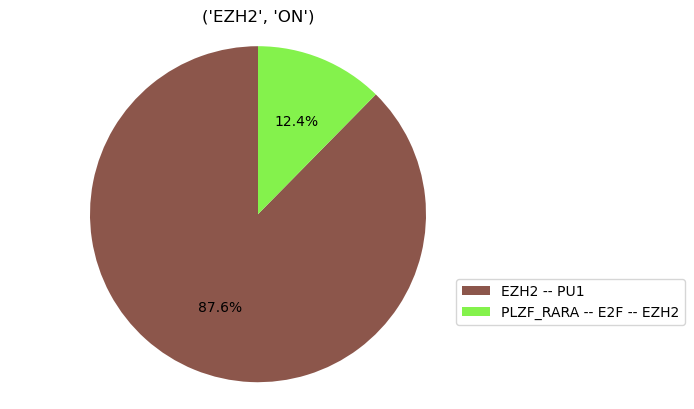

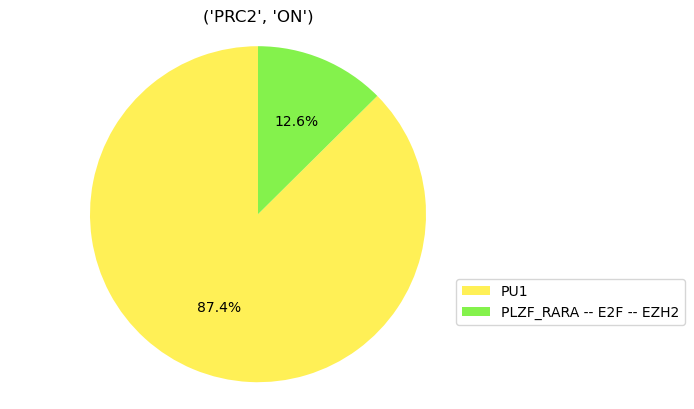

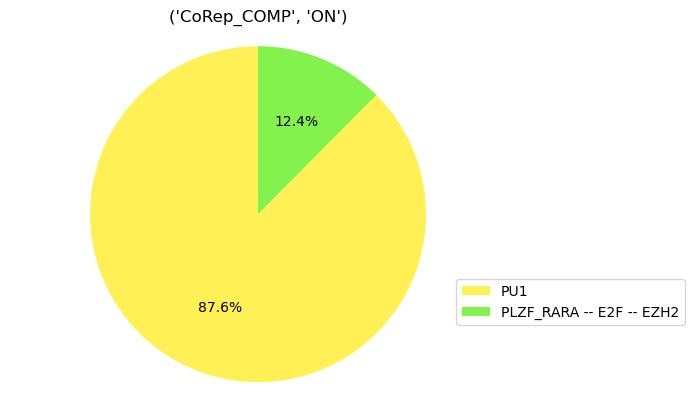

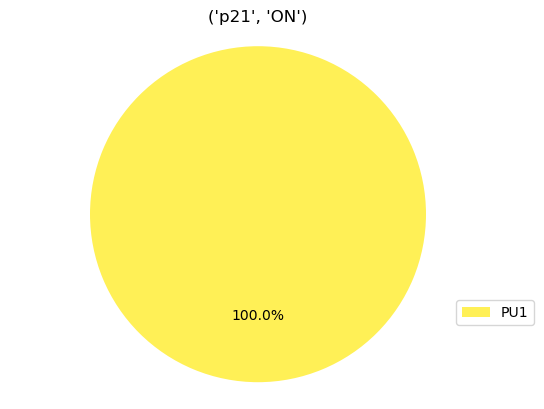

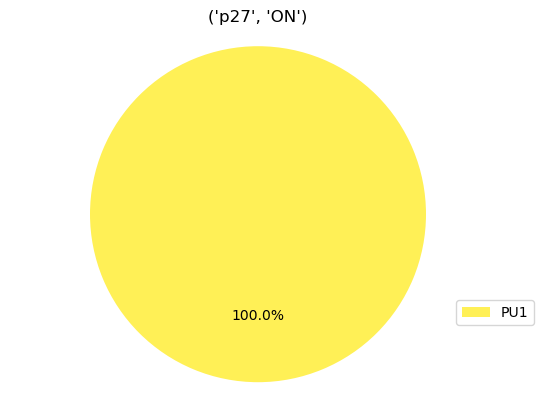

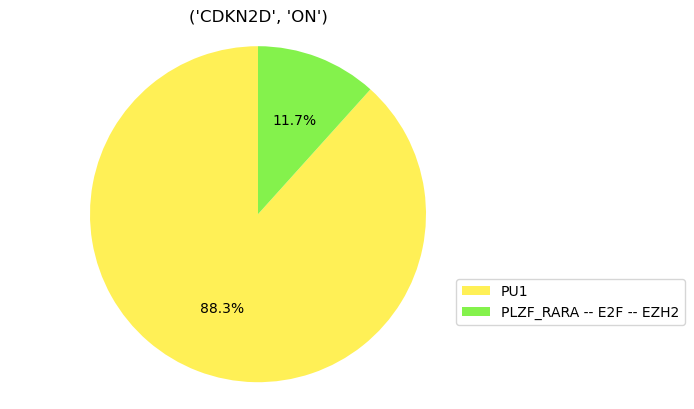

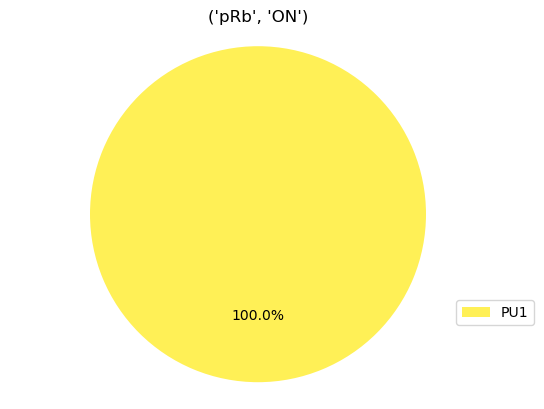

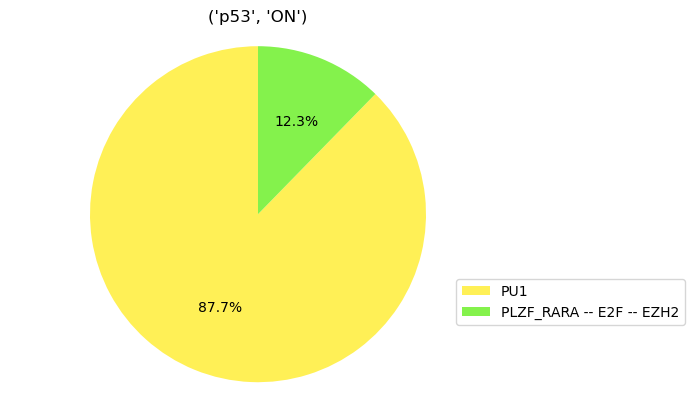

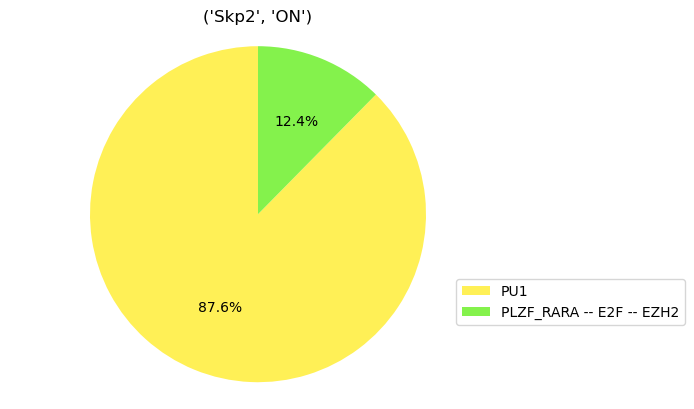

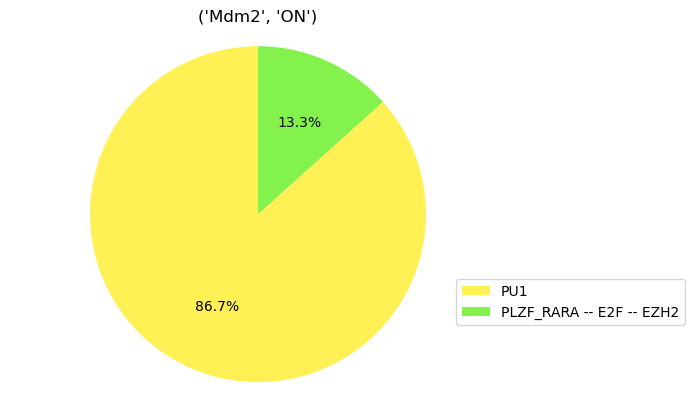

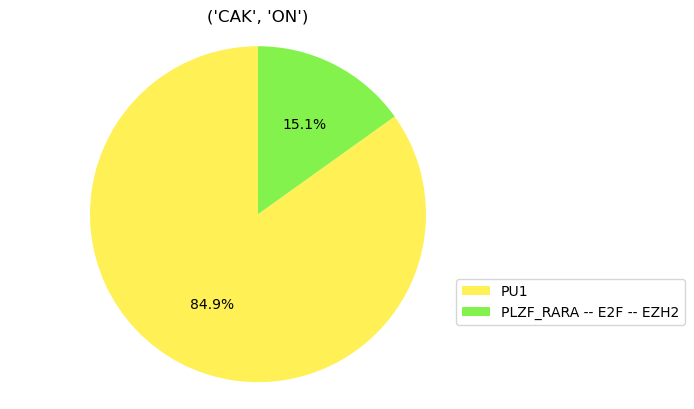

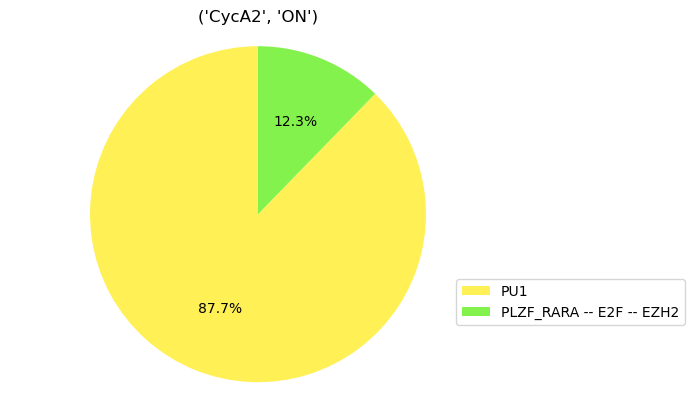

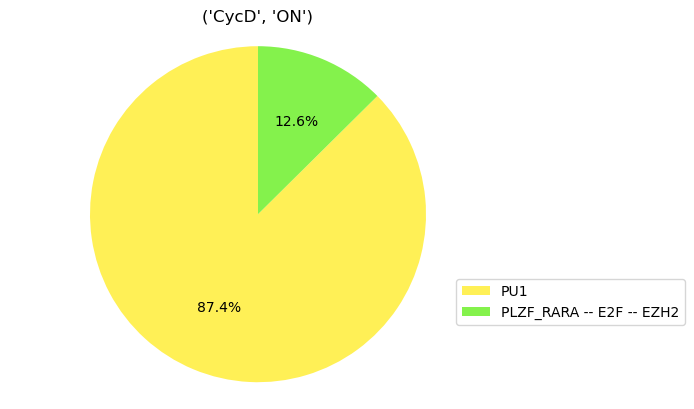

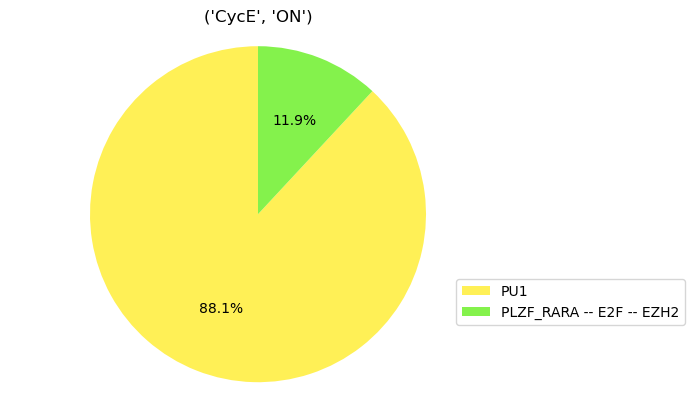

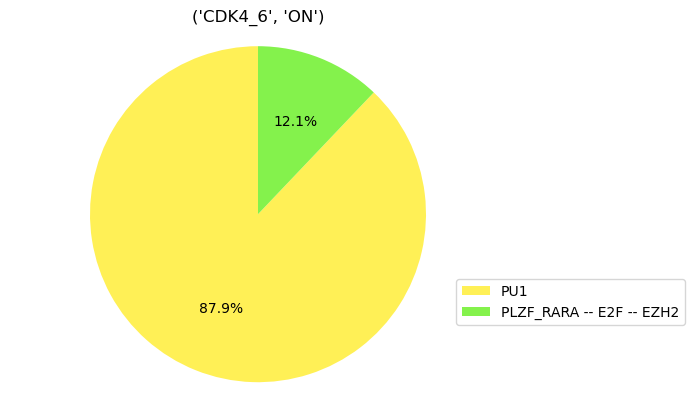

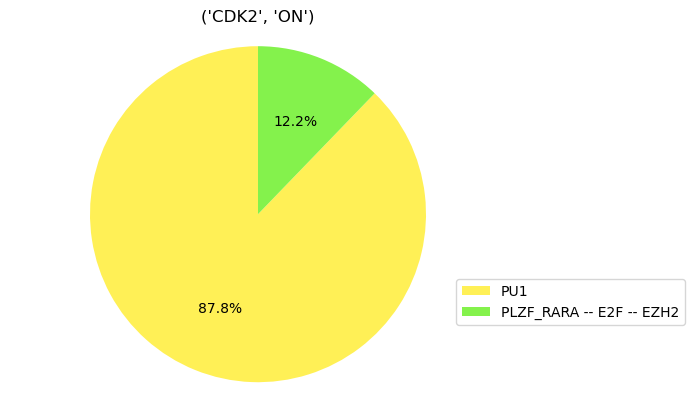

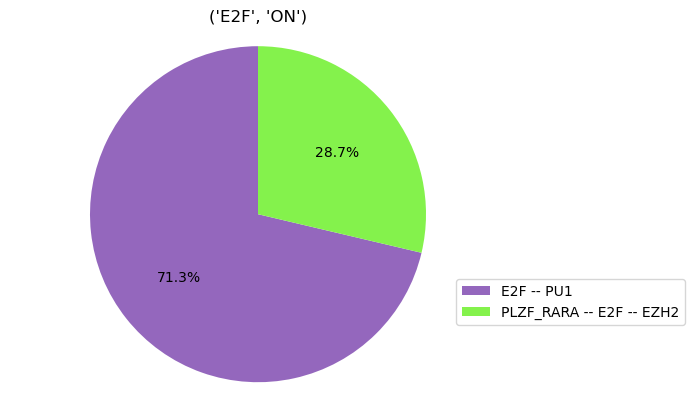

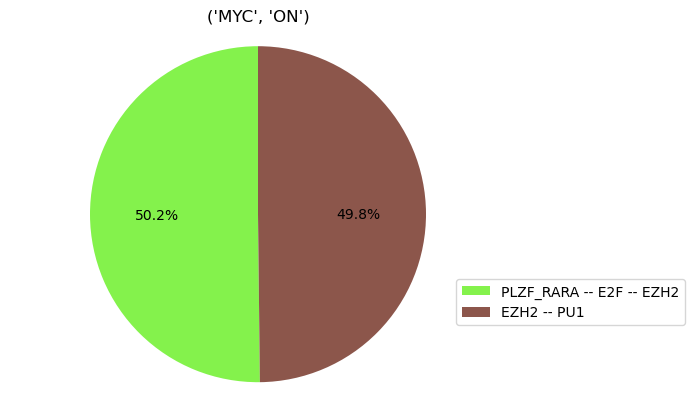

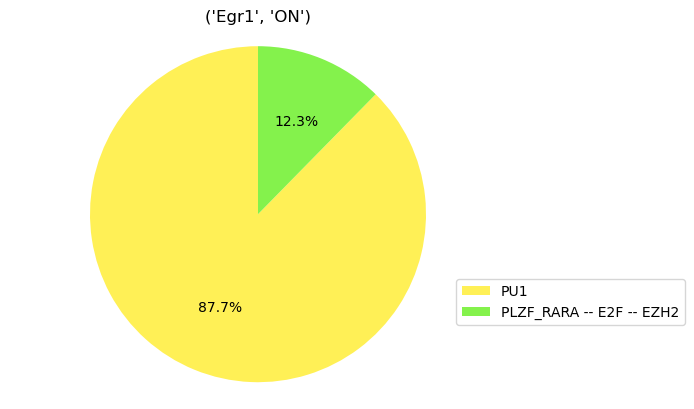

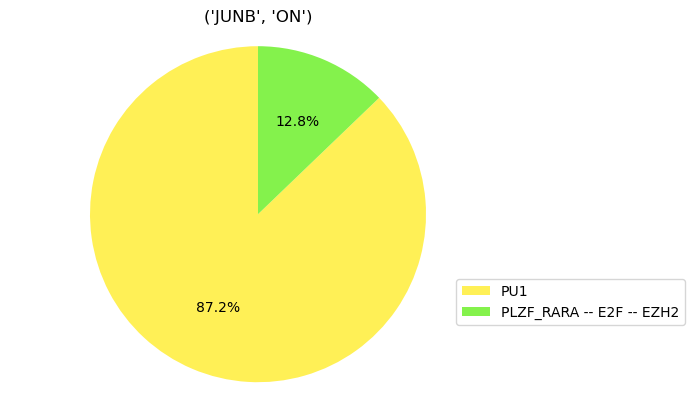

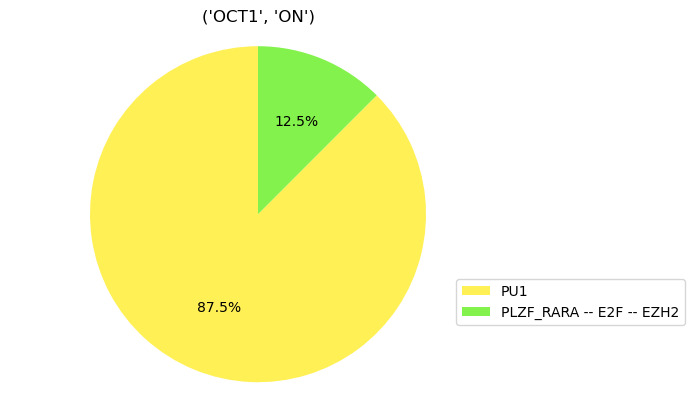

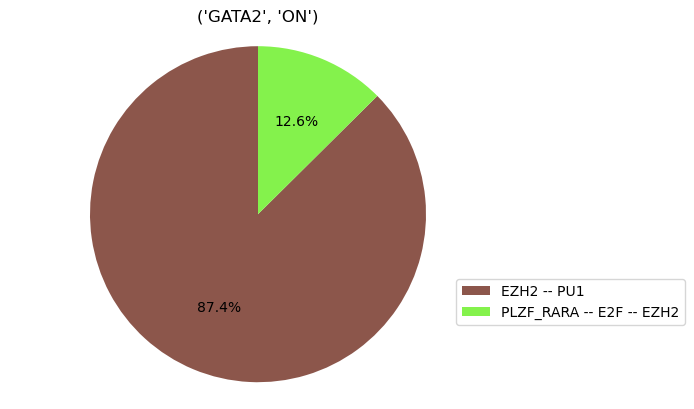

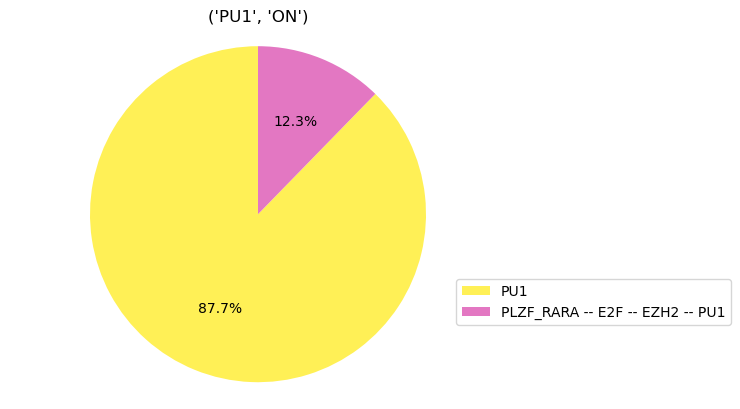

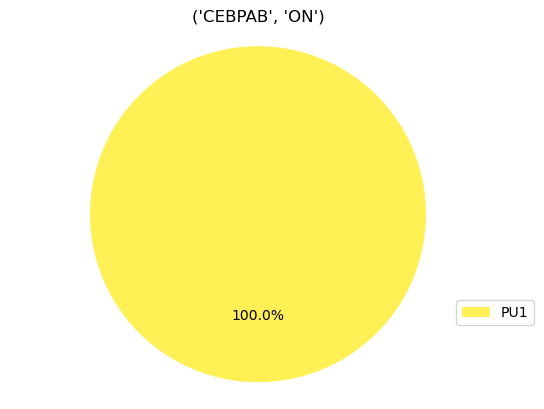

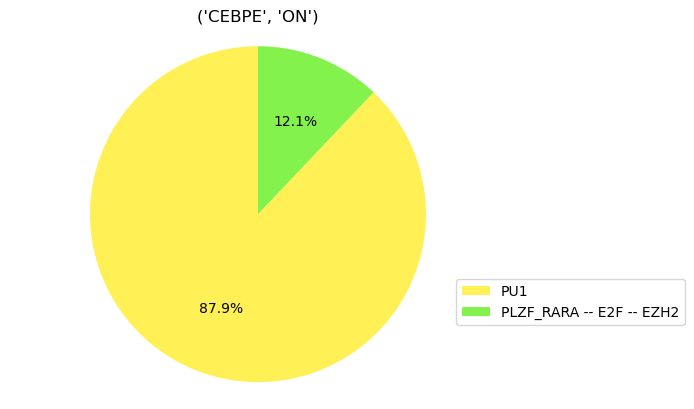

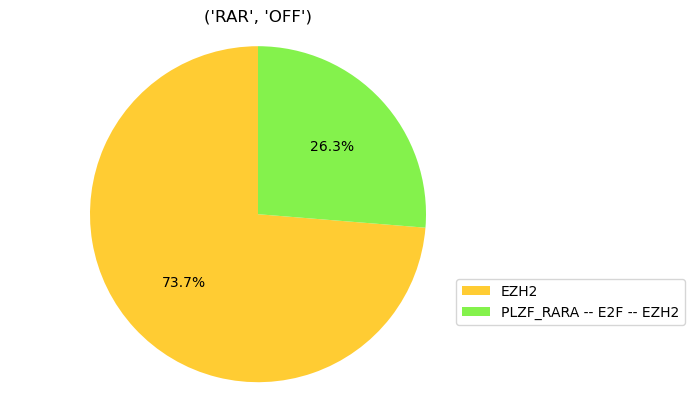

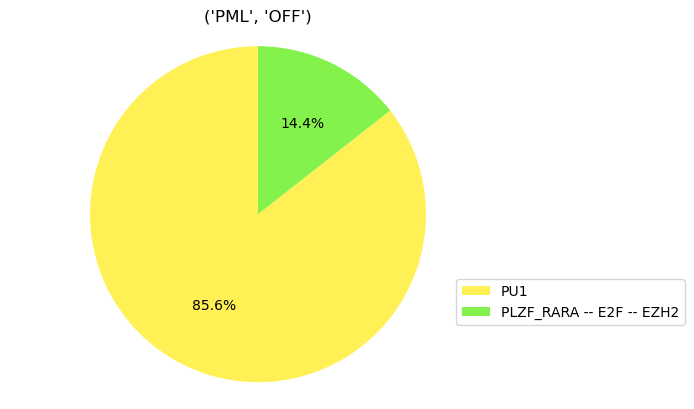

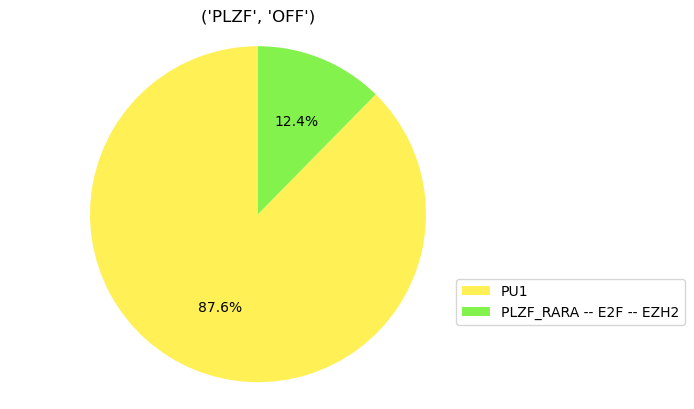

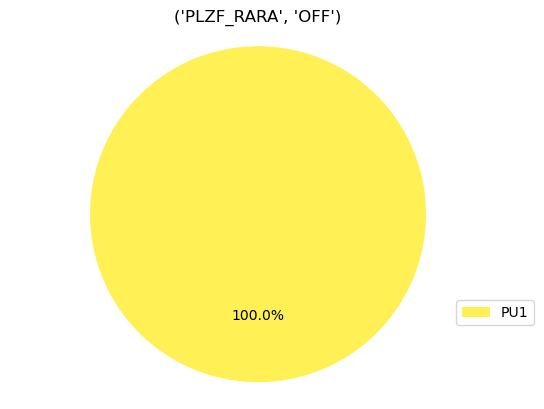

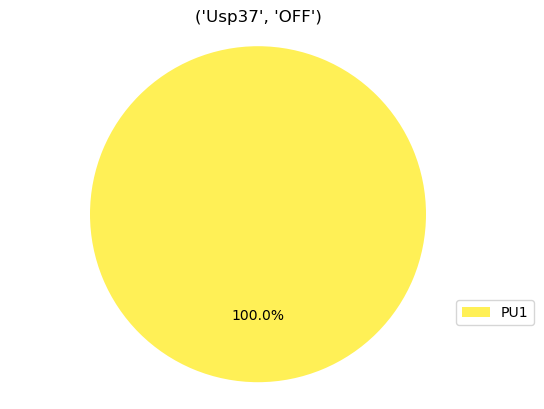

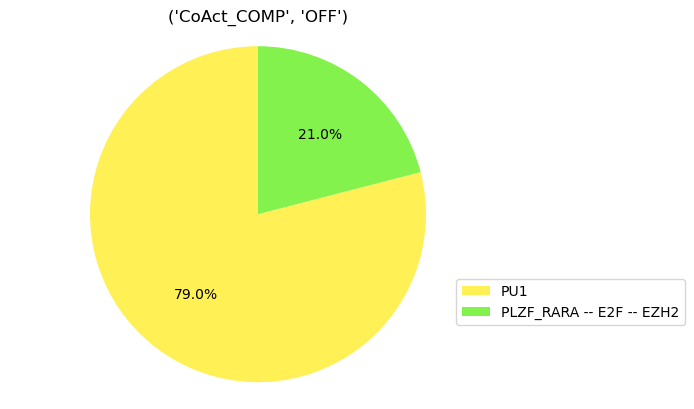

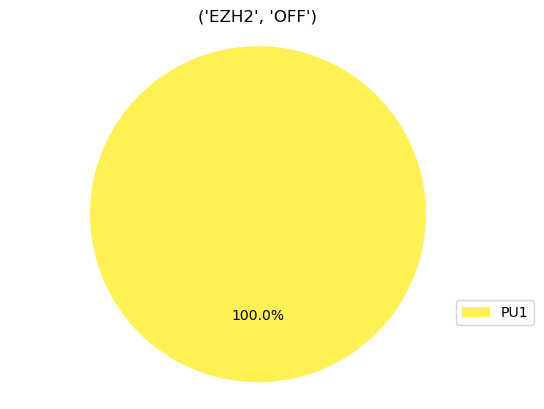

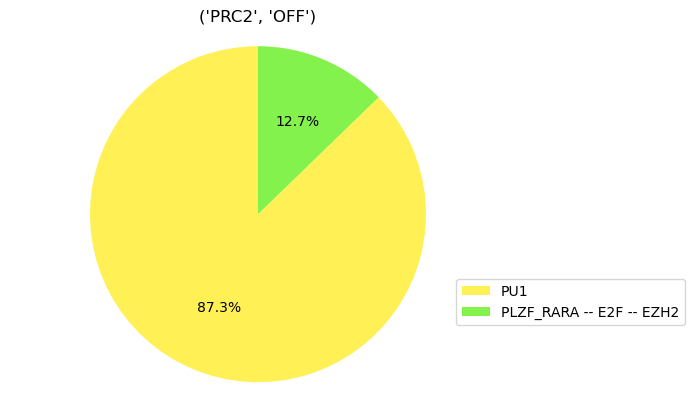

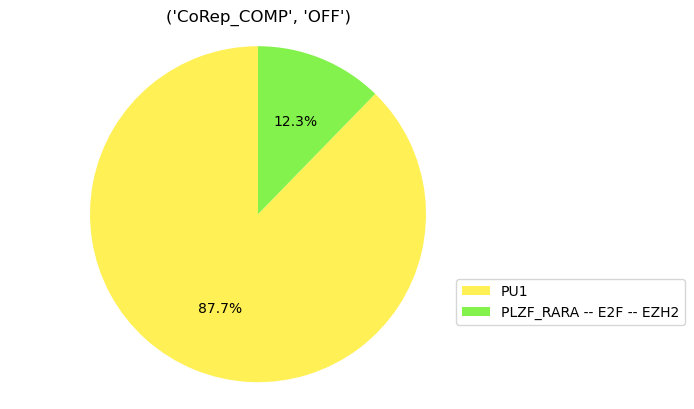

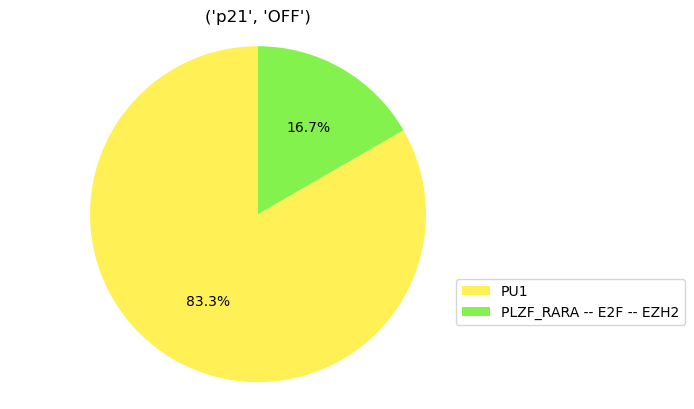

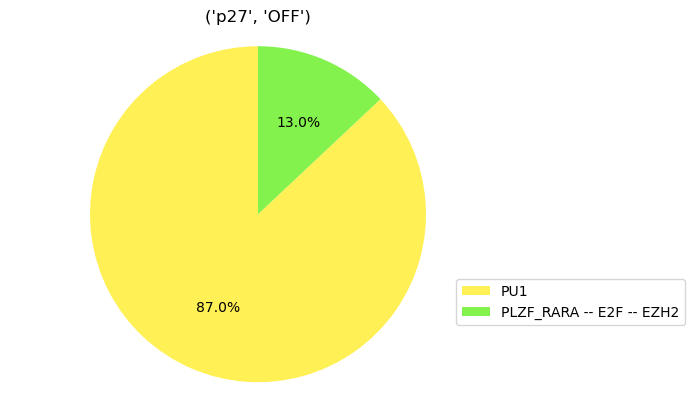

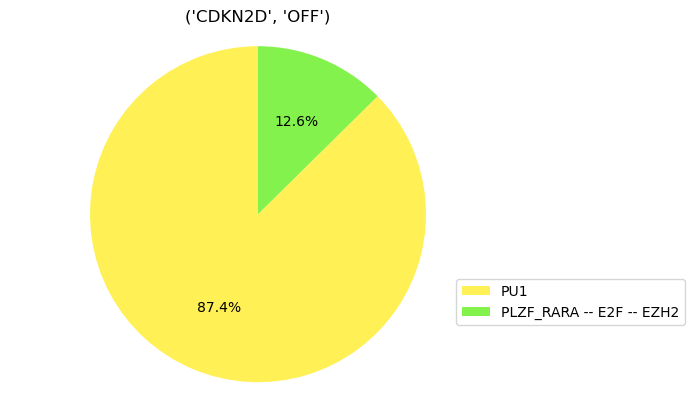

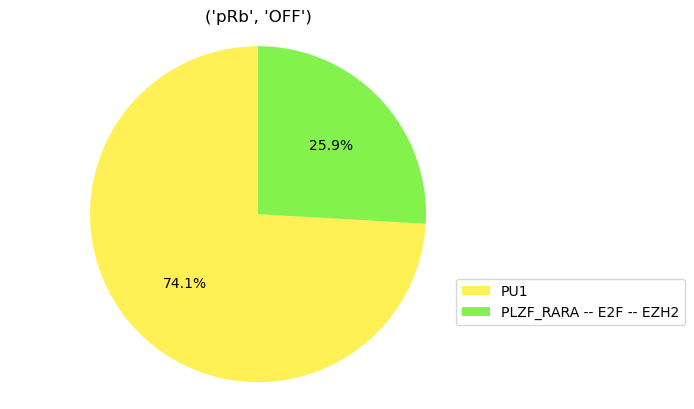

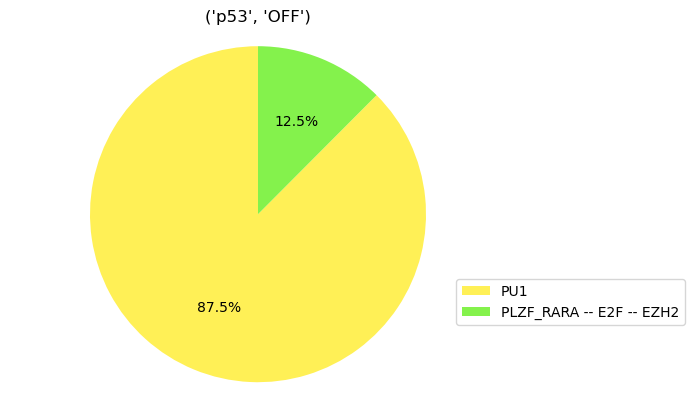

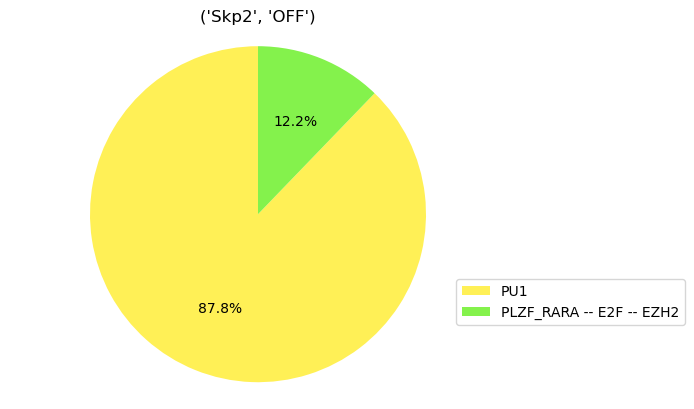

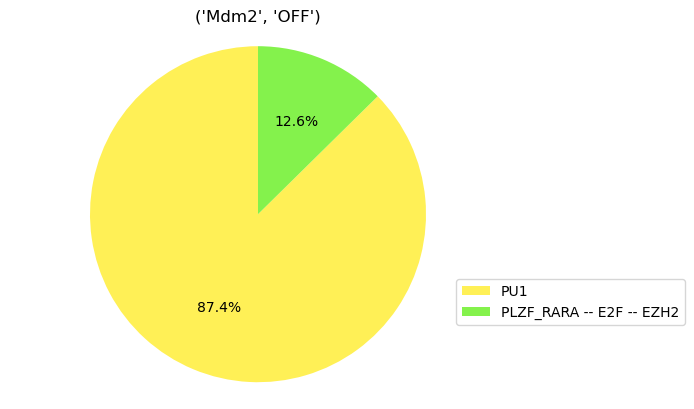

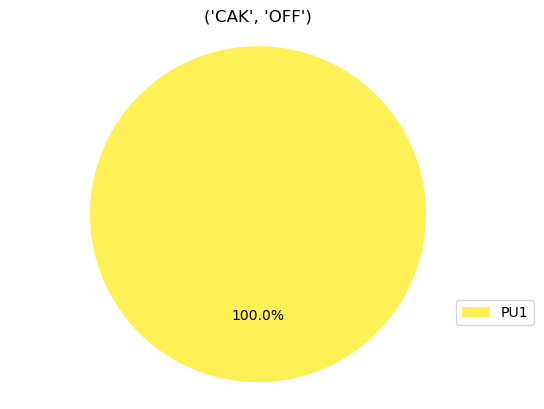

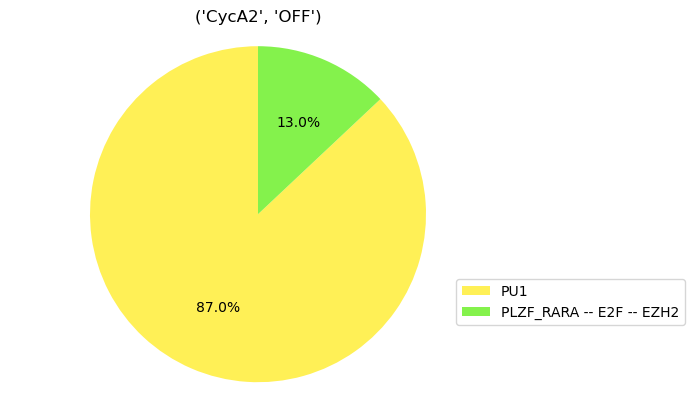

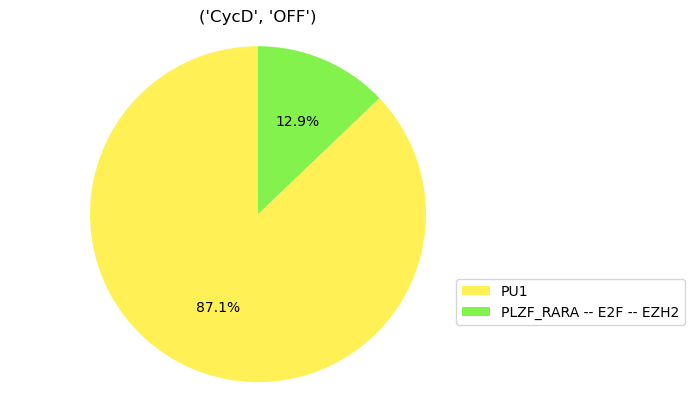

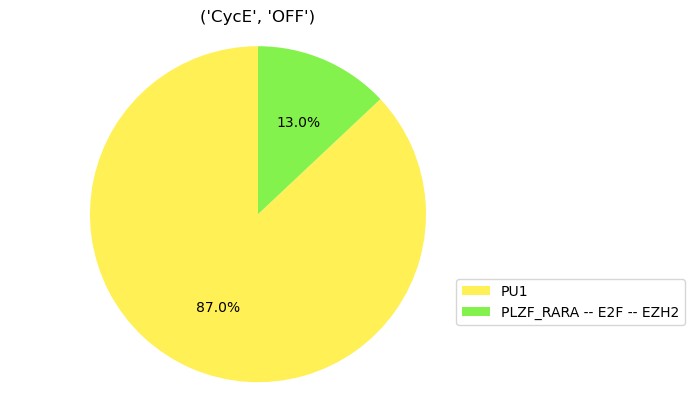

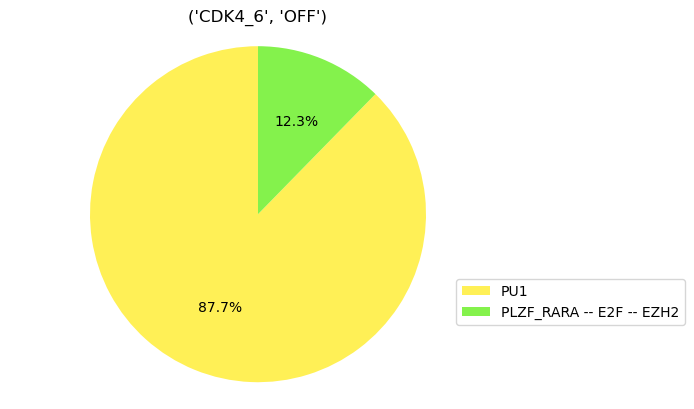

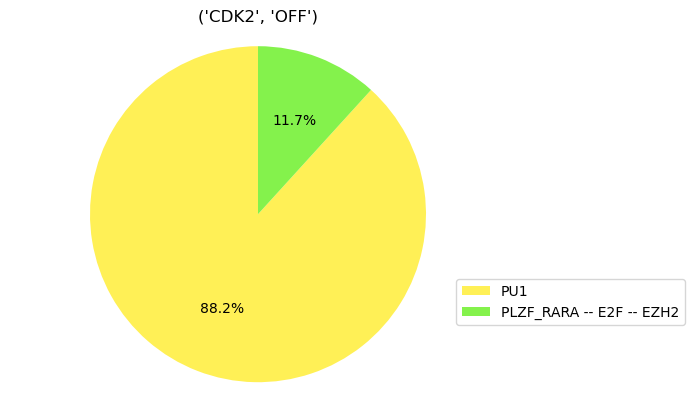

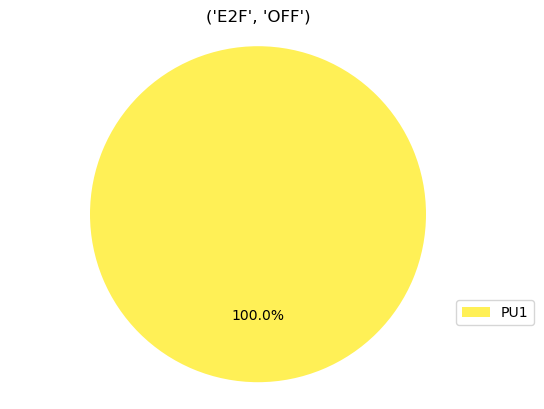

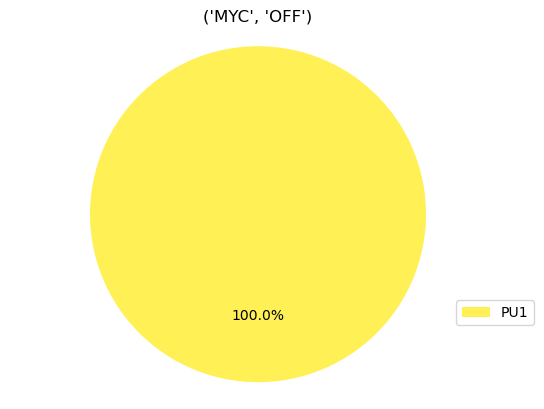

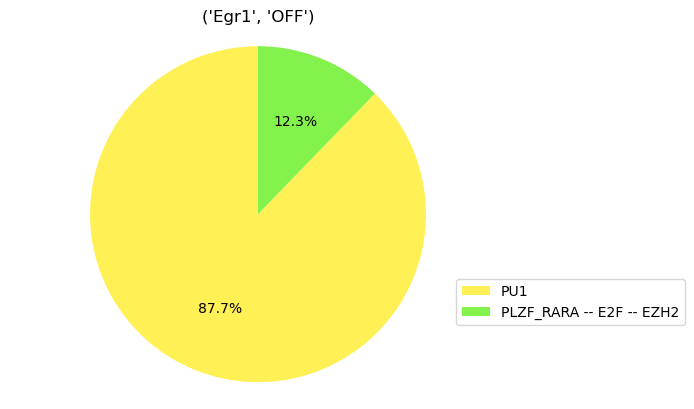

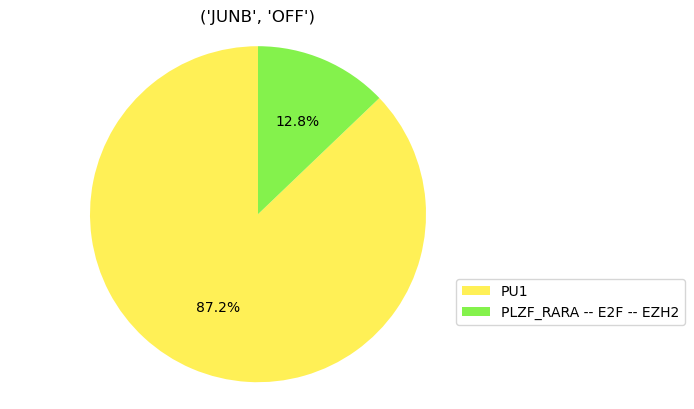

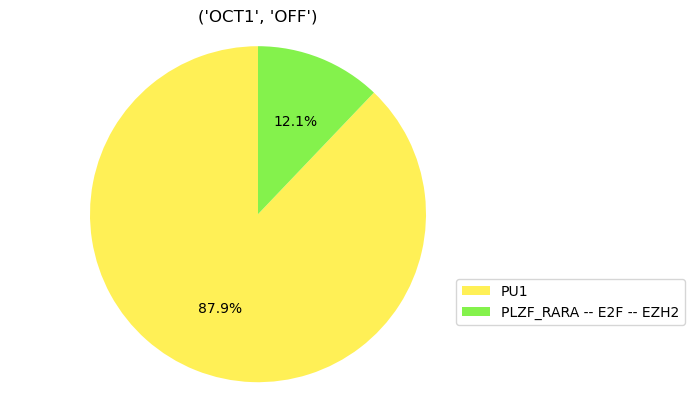

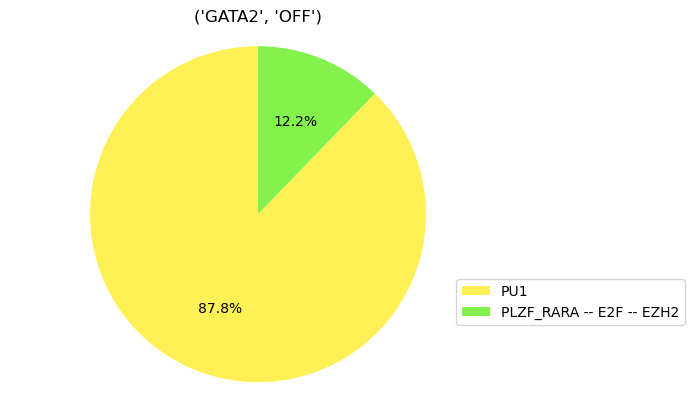

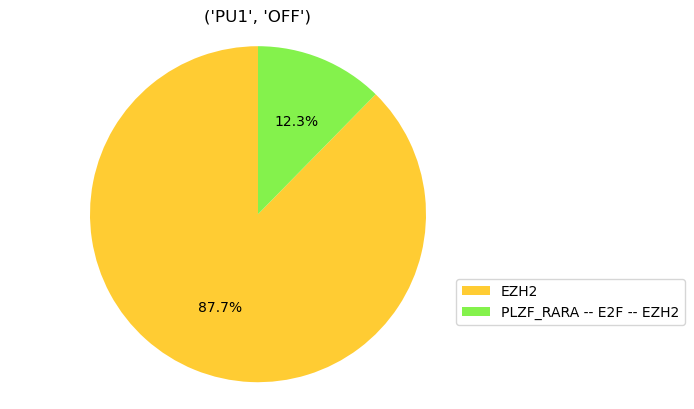

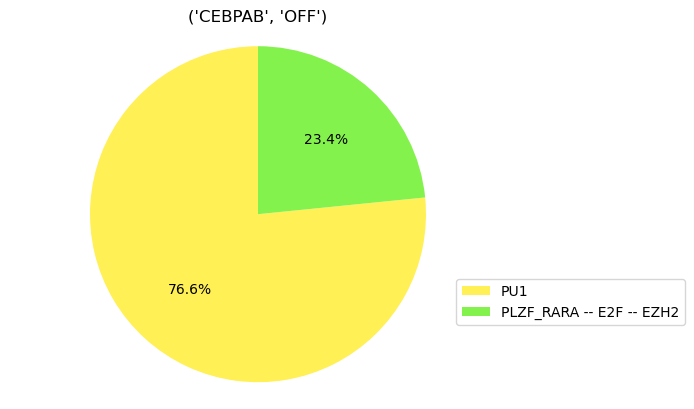

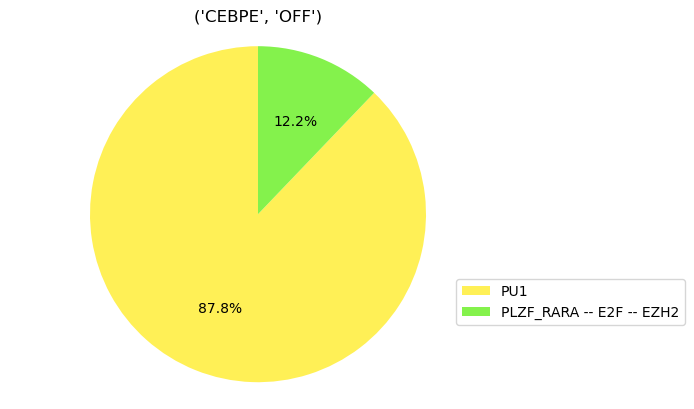

In [15]:
#Comprehensive perturbation analysis with MaBoSS for the identification of nodes affecting the proportions of Differentiation and Proliferation phenotypes.
sensitivity_analysis_nodes = ['RAR', 'PML','PLZF', 'PLZF_RARA', 'Usp37', 'CoAct_COMP', 'EZH2', 'PRC2', 'CoRep_COMP', 'p21', 'p27', 'CDKN2D', 'pRb', 'p53', 'Skp2', 'Mdm2', 'CAK', 'CycA2', 'CycD', 'CycE', 'CDK4_6', 'CDK2', 'E2F', 'MYC', 'Egr1', 'JUNB', 'OCT1', 'GATA2', 'PU1', 'CEBPAB', 'CEBPE']
sensitivity = maboss.pipelines.simulate_single_mutants(mbs, list_nodes=sensitivity_analysis_nodes, sign='BOTH', cmaboss=False)
for cond in sensitivity:
    sensitivity[cond].plot_piechart()
    plt.title(cond)
    
#activate these lines to plot the trajectories    
    #sensitivity[cond].plot_trajectory()
    #plt.title(cond)
    #sensitivity[cond].plot_node_trajectory()
    #plt.title(cond)

This analysis points to key nodes of the network whose perturbations, gain-of-function (GOF) or loss-of-function (LOF) affect the probability to reach the differentiated or proliferative attractors.

Perturbations blocking the reachability towards the differentiated attractor:
* PLZF_RARA GOF
* RAR LOF
* PU1 LOF



Perturbations blocking the reachability towards the proliferative attractor:
* p21 GOF
* p27 GOF
* pRb GOF
* CEBPAB GOF
* PLZF_RARA LOF
* Usp37 LOF
* EZH2 LOF
* CAK LOF
* E2F LOF
* MYC LOF

These simulation results are coherent with published expeimental observations and help to identify potential targets for combinatorial therapies.
Further refinement and analysis of the model, such as the tuning of the initial states or the transition rates used in MaBoSS simulations, could further help to explore the impact of selected pertubations in cell fate decision.